Анализ открытого датасета: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset

#**Поиск пропущенных значений, выбросов, дубликатов и других аномалий**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

df = pd.read_csv('superstore_data.csv')
print(f"Размер датасета: {df.shape}")
print(f"Столбцы: {df.columns.tolist()}\n")

Размер датасета: (2240, 22)
Столбцы: ['Id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Complain']



**Пропущенные значения**


ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ
Столбцы с пропусками:
        Количество пропусков  Процент пропусков
Income                    24               1.07


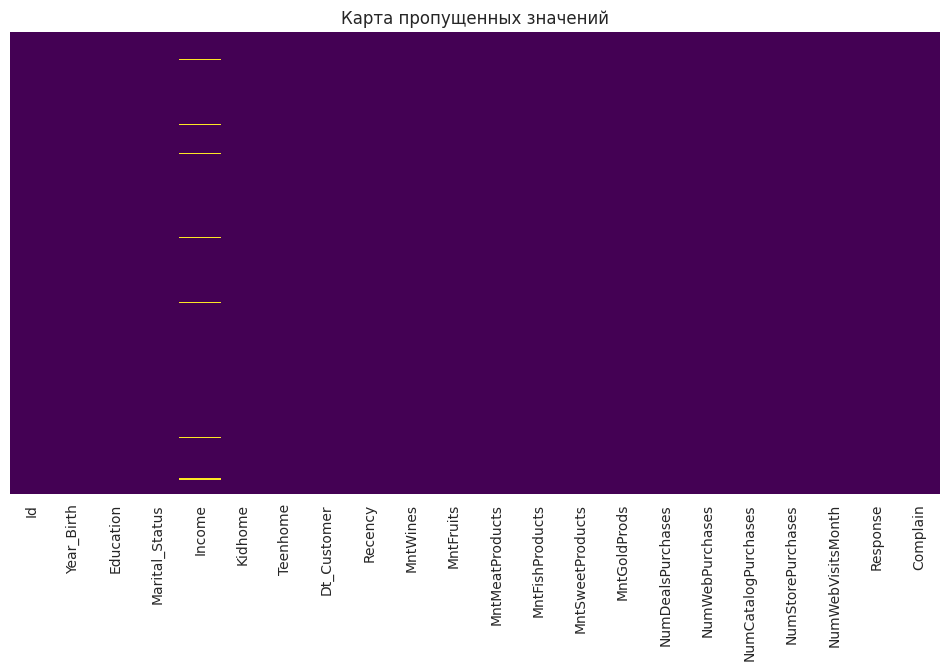

In [ ]:
print("\nПРОПУЩЕННЫЕ ЗНАЧЕНИЯ")
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
missing_df = missing_df[missing_df['Количество пропусков'] > 0]

if len(missing_df) > 0:
    print("Столбцы с пропусками:")
    print(missing_df)
else:
    print("Пропущенных значений нет!")

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Карта пропущенных значений')
plt.show()
print("\n" + "="*50)

**Дубликаты**

In [ ]:
print("\nДУБЛИКАТЫ")
duplicates = df.duplicated().sum()
print(f"Полных дубликатов строк: {duplicates}")

# Частичные дубликаты по ключевым полям
if 'Id' in df.columns:
    id_duplicates = df['Id'].duplicated().sum()
    print(f"Дубликатов в столбце Id: {id_duplicates}")
    if id_duplicates > 0:
        print("Примеры дубликатов ID:")
        duplicate_ids = df[df['Id'].duplicated(keep=False)]['Id'].unique()[:5]
        for dup_id in duplicate_ids:
            print(f"ID {dup_id}: {len(df[df['Id'] == dup_id])} записей")
print("\n" + "="*50)


ДУБЛИКАТЫ
Полных дубликатов строк: 0
Дубликатов в столбце Id: 0



**Аномалии**

In [ ]:
print("\nАНОМАЛИИ В ДАННЫХ")

# Проверка некорректных значений в категориальных столбцах
categorical_cols = df.select_dtypes(include=['object']).columns
print("Уникальные значения в категориальных столбцах:")
for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"\n{col} ({len(unique_vals)} уникальных значений):")
    if len(unique_vals) > 10:
        print(f"Первые 10 значений: {unique_vals[:10]}")
    else:
        print(f"Все значения: {unique_vals}")

    if len(unique_vals) < 15:  # Распределение
        print("Распределение:")
        value_counts = df[col].value_counts()
        for val, count in value_counts.items():
            percent = count / len(df) * 100
            print(f"  '{val}': {count} записей ({percent:.1f}%)")
    else:
        print(f"Распределение (первые 10):")
        top_values = df[col].value_counts().head(10)
        for val, count in top_values.items():
            percent = count / len(df) * 100
            print(f"  '{val}': {count} записей ({percent:.1f}%)")

        # Проверка на странные значения
        suspicious_values = ['unknown', 'Unknown', 'N/A', 'n/a', 'NA', 'NaN', 'null', 'NULL', '', ' ']
        for suspect in suspicious_values:
            if suspect in df[col].values:
                count = (df[col] == suspect).sum()
                if count > 0:
                    print(f"  Найдено подозрительное значение '{suspect}': {count} раз")
print("\n" + "-"*50)

# Проверка числовых столбцов на выбросы и нереальные значения
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nПроверка числовых столбцов на выбросы (метод IQR):")

for col in numeric_cols:
    # Пропус столбцов с одним значением или бинарные/категориальные
    if df[col].nunique() <= 2:
        continue  # Пропускаем бинарные столбцы

    # Столбец не содержит только NaN
    if df[col].isnull().all():
        print(f"\n{col}: Все значения пропущены")
        continue

    # Удаление NaN для расчета квантилей
    col_data = df[col].dropna()

    # После удаления NaN осталось достаточно данных
    if len(col_data) < 4:
        print(f"\n{col}: Недостаточно данных для анализа ({len(col_data)} значений)")
        continue

    try:
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1

        # Проверка на случай, если IQR = 0 (все значения одинаковые или почти)
        if IQR == 0:
            # Сандартное отклонение для границ
            std = col_data.std()
            if std == 0:
                print(f"\n{col}: Все значения одинаковые ({col_data.iloc[0]})")
                continue
            lower_bound = col_data.mean() - 3 * std
            upper_bound = col_data.mean() + 3 * std
        else:
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

        # Выбросы
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound) & (df[col].notna())]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outlier_percent = round(outlier_count / len(df) * 100, 2)

            print(f"\n{col}:")
            print(f"  Выбросов: {outlier_count} ({outlier_percent}%)")
            print(f"  Диапазон выбросов: {outliers[col].min():.2f} - {outliers[col].max():.2f}")
            print(f"  Границы IQR: [{lower_bound:.2f}, {upper_bound:.2f}]")
            print(f"  Минимум: {df[col].min():.2f}, Максимум: {df[col].max():.2f}")
            print(f"  Q1: {Q1:.2f}, Медиана: {col_data.median():.2f}, Q3: {Q3:.2f}")

            # Проверка на отрицательные значения в столбцах, где они недопустимы
            if 'Mnt' in col or 'Income' in col or 'Num' in col:
                negative_values = df[df[col] < 0][col]
                if len(negative_values) > 0:
                    print(f"  ВНИМАНИЕ: Отрицательные значения: {len(negative_values)} записей")
    except Exception as e:
        print(f"\n{col}: Ошибка при анализе - {str(e)}")

print("\n" + "-"*50)

# Дополнительные проверки аномалий
print("\nДополнительные проверки аномалий:")

# Нелогичные комбинации
if 'Year_Birth' in df.columns:
    df['Age'] = 2026 - df['Year_Birth']  # Текущий год 2026
    unusual_age = df[(df['Age'] < 18) | (df['Age'] > 100)]
    if len(unusual_age) > 0:
        print(f"• Нереальный возраст (<18 или >100): {len(unusual_age)} записей")
        print(f"  Минимальный возраст: {df['Age'].min():.0f} лет")
        print(f"  Максимальный возраст: {df['Age'].max():.0f} лет")
    df = df.drop(columns=['Age'], errors='ignore')

# Проверка доходов
if 'Income' in df.columns:
    zero_income = df[df['Income'] == 0]
    negative_income = df[df['Income'] < 0]
    extreme_income = df[df['Income'] > 1000000]  # Доход больше 1 миллиона

    if len(zero_income) > 0:
        print(f"• Нулевой доход: {len(zero_income)} записей")
    if len(negative_income) > 0:
        print(f"• Отрицательный доход: {len(negative_income)} записей")
    if len(extreme_income) > 0:
        print(f"• Экстремально высокий доход (>1M): {len(extreme_income)} записей")

# Проверка суммы покупок
product_cols = [col for col in df.columns if 'Mnt' in col]
for col in product_cols:
    negative_purchases = df[df[col] < 0]
    if len(negative_purchases) > 0:
        print(f"• Отрицательные значения в {col}: {len(negative_purchases)} записей")

print("\n" + "-"*50)


АНОМАЛИИ В ДАННЫХ
Уникальные значения в категориальных столбцах:

Education (5 уникальных значений):
Все значения: ['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
Распределение:
  'Graduation': 1127 записей (50.3%)
  'PhD': 486 записей (21.7%)
  'Master': 370 записей (16.5%)
  '2n Cycle': 203 записей (9.1%)
  'Basic': 54 записей (2.4%)

Marital_Status (8 уникальных значений):
Все значения: ['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
Распределение:
  'Married': 864 записей (38.6%)
  'Together': 580 записей (25.9%)
  'Single': 480 записей (21.4%)
  'Divorced': 232 записей (10.4%)
  'Widow': 77 записей (3.4%)
  'Alone': 3 записей (0.1%)
  'YOLO': 2 записей (0.1%)
  'Absurd': 2 записей (0.1%)

--------------------------------------------------

Проверка числовых столбцов на выбросы (метод IQR):

Year_Birth:
  Выбросов: 3 (0.13%)
  Диапазон выбросов: 1893.00 - 1900.00
  Границы IQR: [1932.00, 2004.00]
  Минимум: 1893.00, Максимум: 1996.00
  Q1: 1959.00, Меди

**Визуализация**


ВИЗУАЛИЗАЦИЯ ВЫБРОСОВ


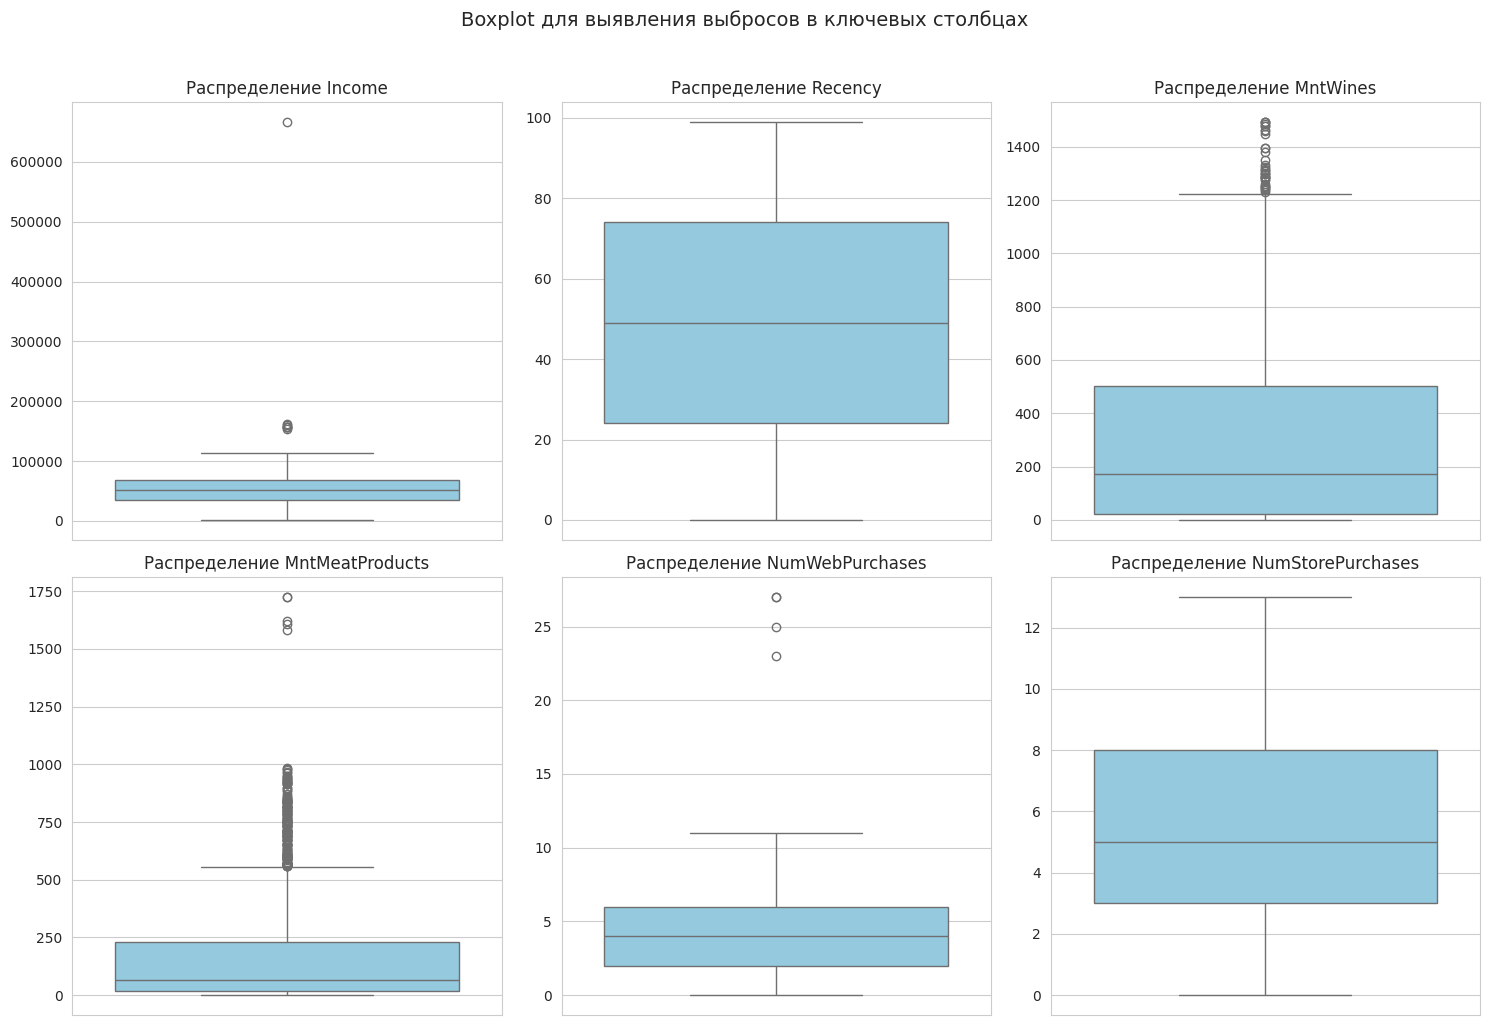

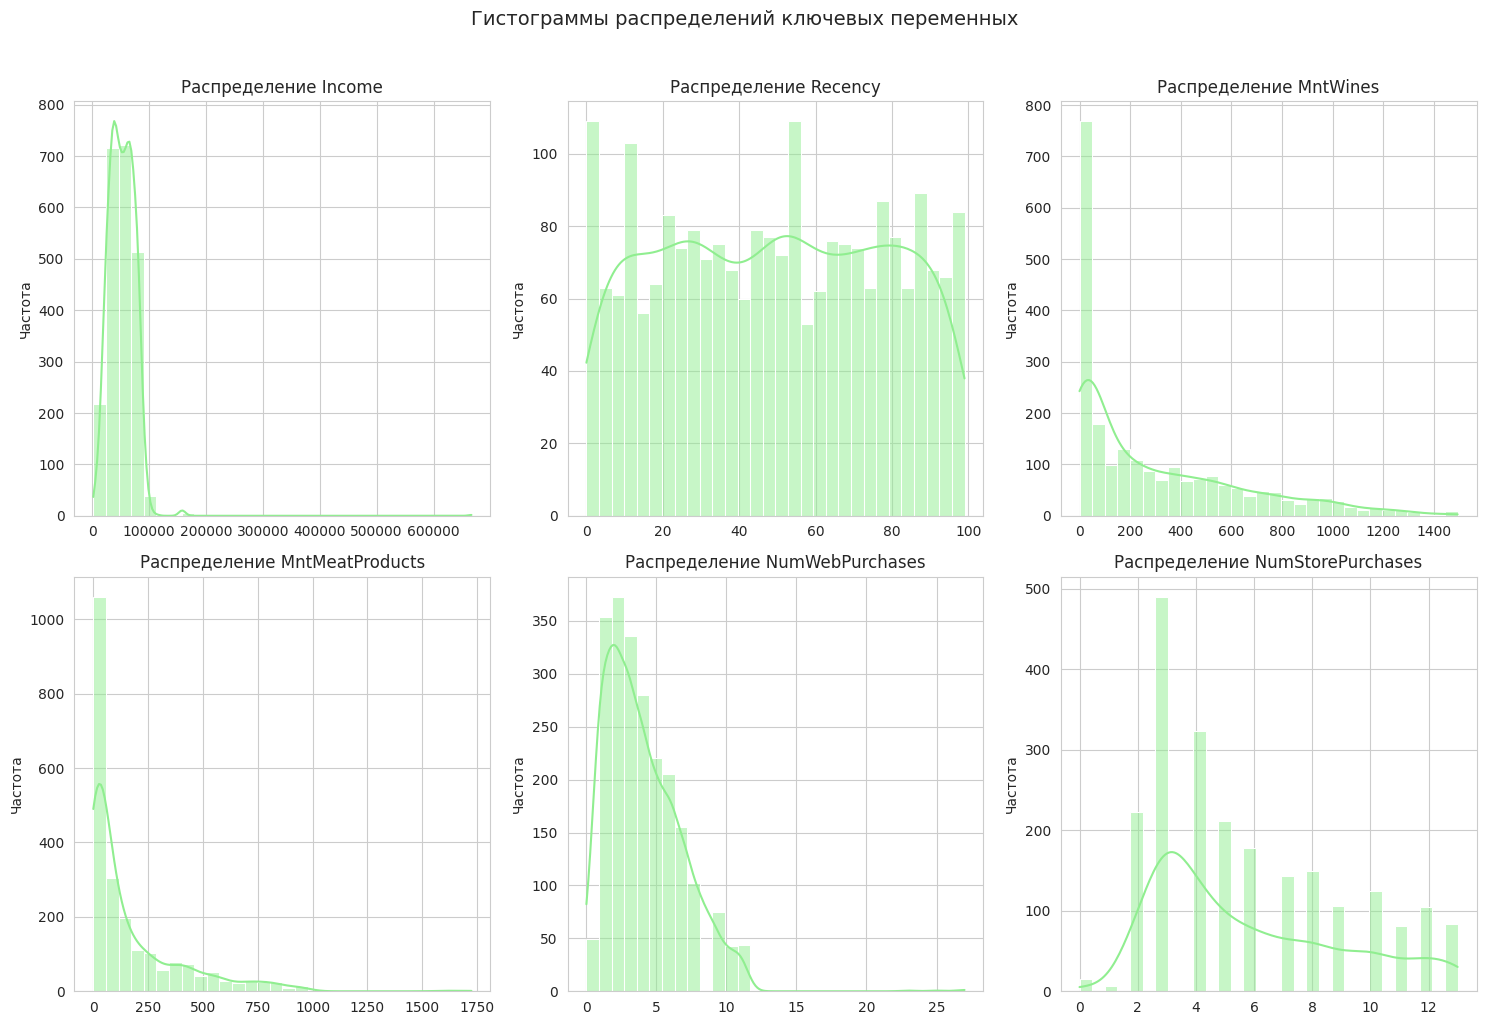

In [ ]:
print("\nВИЗУАЛИЗАЦИЯ ВЫБРОСОВ")

# Ключевые числовые столбцы для визуализации
key_numeric_cols = ['Income', 'Recency', 'MntWines', 'MntMeatProducts', 'NumWebPurchases', 'NumStorePurchases']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(key_numeric_cols):
    if col in df.columns:
        # Boxplot
        sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_ylabel('')

plt.suptitle('Boxplot для выявления выбросов в ключевых столбцах', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Гистограммы распределений
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(key_numeric_cols):
    if col in df.columns:
        # Histogram
        sns.histplot(data=df, x=col, kde=True, ax=axes[i], bins=30, color='lightgreen')
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Частота')

plt.suptitle('Гистограммы распределений ключевых переменных', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
print("\n" + "="*50)

**Прочее**


НЕСОГЛАСОВАННОСТЬ ДАННЫХ
Возрастной диапазон: 30 - 133 лет
Записей с нереальным возрастом (<18 или >100): 3

Доходы:
Минимальный доход: $1730.00
Максимальный доход: $666666.00
Медианный доход: $51381.50
Записей с отрицательным доходом: 0

Некорректных дат в Dt_Customer: 0
Диапазон дат регистрации: 2012-01-08 00:00:00 - 2014-12-06 00:00:00


МАТРИЦА КОРРЕЛЯЦИЙ


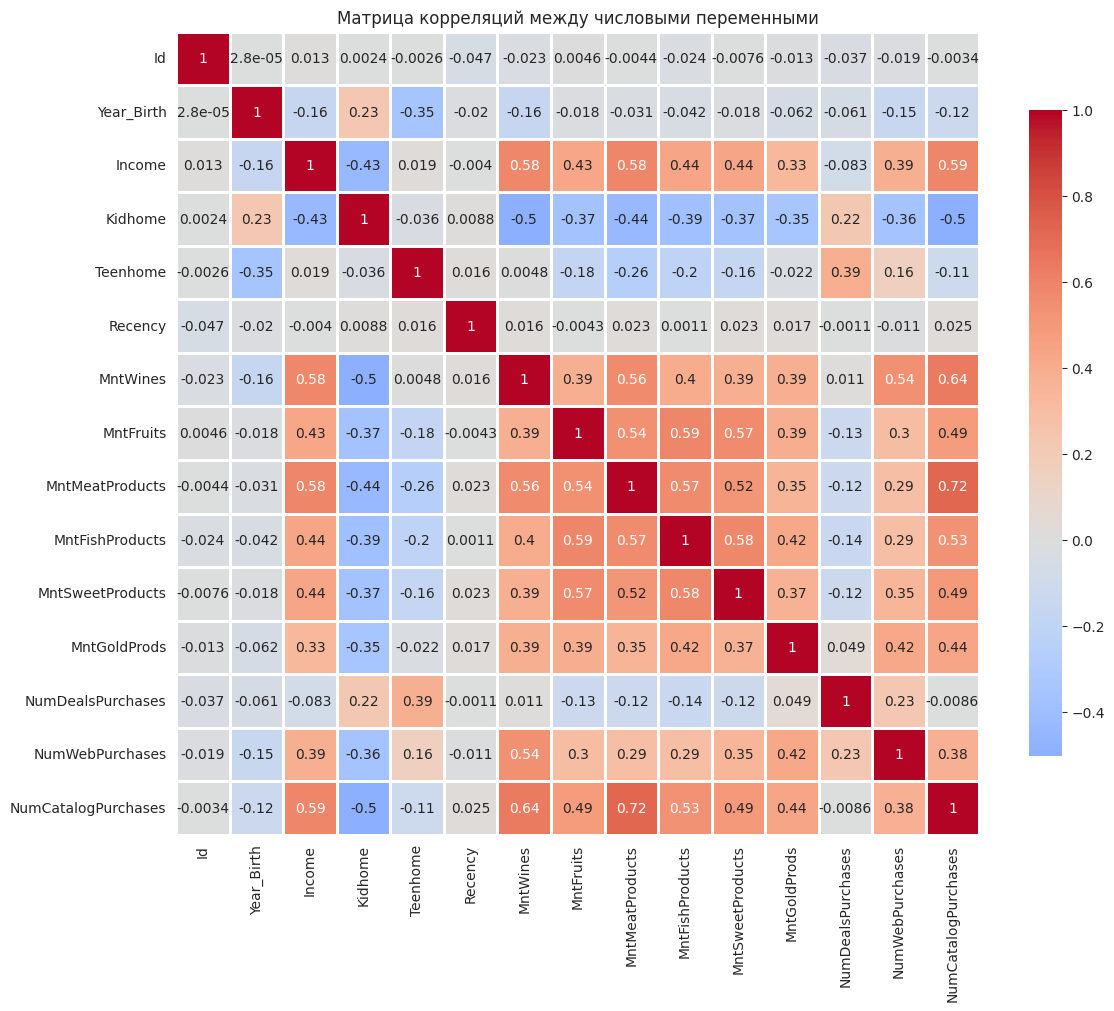


Сильные корреляции (>0.7):
   • MntMeatProducts и NumCatalogPurchases: 0.724


In [ ]:
print("\nНЕСОГЛАСОВАННОСТЬ ДАННЫХ")

# Проверка возраста
if 'Year_Birth' in df.columns:
    current_year = 2026  # Предполагаемый текущий год
    df['Age'] = current_year - df['Year_Birth']
    print(f"Возрастной диапазон: {df['Age'].min()} - {df['Age'].max()} лет")

    # Проверка на нереальный возраст
    unrealistic_age = df[(df['Age'] < 18) | (df['Age'] > 100)]
    print(f"Записей с нереальным возрастом (<18 или >100): {len(unrealistic_age)}")

# Проверка доходов
if 'Income' in df.columns:
    print(f"\nДоходы:")
    print(f"Минимальный доход: ${df['Income'].min():.2f}")
    print(f"Максимальный доход: ${df['Income'].max():.2f}")
    print(f"Медианный доход: ${df['Income'].median():.2f}")

    # Проверка на отрицательные доходы
    negative_income = df[df['Income'] < 0]
    print(f"Записей с отрицательным доходом: {len(negative_income)}")

# Проверка дат
if 'Dt_Customer' in df.columns:
    try:
        df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%m/%d/%Y', errors='coerce')
        invalid_dates = df['Dt_Customer'].isnull().sum()
        print(f"\nНекорректных дат в Dt_Customer: {invalid_dates}")

        if invalid_dates == 0:
            print(f"Диапазон дат регистрации: {df['Dt_Customer'].min()} - {df['Dt_Customer'].max()}")
    except:
        print("Ошибка при обработке дат")

# Проверка сумм продуктов (не могут быть отрицательными)
product_cols = [col for col in df.columns if 'Mnt' in col]
for col in product_cols:
    negative_values = df[df[col] < 0]
    if len(negative_values) > 0:
        print(f"Отрицательные значения в {col}: {len(negative_values)}")

# Проверка количества покупок (должны быть целыми неотрицательными числами)
purchase_cols = [col for col in df.columns if 'Num' in col and 'Purchases' in col]
for col in purchase_cols:
    negative_counts = df[df[col] < 0]
    if len(negative_counts) > 0:
        print(f"Отрицательные значения в {col}: {len(negative_counts)}")
print("\n" + "="*50)


print("\nМАТРИЦА КОРРЕЛЯЦИЙ")

# Только числовые столбцы для корреляции
corr_cols = numeric_cols.tolist()
# Ограничение количества столбцов для лучшей визуализации
if len(corr_cols) > 15:
    corr_cols = corr_cols[:15]

if len(corr_cols) > 1:
    corr_matrix = df[corr_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Матрица корреляций между числовыми переменными')
    plt.tight_layout()
    plt.show()

# Вывод сильных корреляций
strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j],
                               corr_matrix.iloc[i, j].round(3)))

if strong_corr:
    print("\nСильные корреляции (>0.7):")
    for corr in strong_corr:
        print(f"   • {corr[0]} и {corr[1]}: {corr[2]}")
else:
    print("\nСильных корреляций не обнаружено")

**Выводы**

In [ ]:
print("\nСВОДКА ВЫВОДОВ")

print("\n1. СТРУКТУРА ДАТАСЕТА:")
print(f"   • Всего записей: {df.shape[0]}")
print(f"   • Всего признаков: {df.shape[1]}")
print(f"   • Числовых признаков: {len(numeric_cols)}")
print(f"   • Категориальных признаков: {len(categorical_cols)}")

print("\n2. КАЧЕСТВО ДАННЫХ:")
# Пропуски
if 'Income' in df.columns and df['Income'].isnull().sum() > 0:
    print(f"   • Есть пропуски в Income: {df['Income'].isnull().sum()} записей")

print("\n3. АНОМАЛИИ:")
# Дубликаты
if duplicates > 0:
    print(f"   • Обнаружены полные дубликаты: {duplicates} записей")

# Выбросы
if 'Income' in df.columns:
    Q1 = df['Income'].quantile(0.25)
    Q3 = df['Income'].quantile(0.75)
    IQR = Q3 - Q1
    income_outliers = df[(df['Income'] < Q1 - 1.5*IQR) | (df['Income'] > Q3 + 1.5*IQR)]
    print(f"   • Выбросы в Income: {len(income_outliers)} записей")

print("\n4. РЕКОМЕНДАЦИИ ПО ОБРАБОТКЕ:")
print("   • Обработать пропуски в Income (заполнить медианой или удалить)")
print("   • Проверить выбросы в ключевых числовых переменных")
print("   • Удалить полные дубликаты, если они есть")
print("   • Проверить некорректные значения в категориальных переменных")
print("   • Привести даты к единому формату")




СВОДКА ВЫВОДОВ

1. СТРУКТУРА ДАТАСЕТА:
   • Всего записей: 2240
   • Всего признаков: 23
   • Числовых признаков: 19
   • Категориальных признаков: 3

2. КАЧЕСТВО ДАННЫХ:
   • Есть пропуски в Income: 24 записей

3. АНОМАЛИИ:
   • Выбросы в Income: 8 записей

4. РЕКОМЕНДАЦИИ ПО ОБРАБОТКЕ:
   • Обработать пропуски в Income (заполнить медианой или удалить)
   • Проверить выбросы в ключевых числовых переменных
   • Удалить полные дубликаты, если они есть
   • Проверить некорректные значения в категориальных переменных
   • Привести даты к единому формату
